# **Deep Learning Project: Garbage Classification -  Best Models**

My approach to model creation involved dividing my work into several notebooks, each dedicated to specific types of data and models. I had one notebook for pre-trained models, and two for custom models—one for 50x50 pixel size images and another for 128x128. I then consolidated the top-performing models from each category into a notebook named 'Best Models.' Finally, I conducted a manual grid search in a separate notebook to further optimize the best-performing models.

This particular notebook is dedicated to consolidating the top-performing models from the three modeling notebooks.

## 1. Size 50x50 pixels

### 1.1 Import Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Metric

from keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

### 1.2 Import the splited data

In [2]:
# Function to load images data and corresponding labels from a directory
def load_data_from_directory(directory):
    # Lists to store the file paths as well as the labels of the images
    file_paths = []
    class_labels = []
    # Walk through the directory
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        # Make sure to ignore any non-directory entries
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                # Check if the file is a JPEG image
                if filename.endswith('.jpg'):
                    file_paths.append(file_path)
                    class_labels.append(class_name)
    # Convert class labels to numeric
    unique_classes = np.unique(class_labels)
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
    numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]
    return file_paths, numeric_labels, class_to_idx

# Define directories
split_dir = "./resized and split 50/train_test_val_50"
train_dir = os.path.join(split_dir, 'train')
test_dir = os.path.join(split_dir, 'test')
val_dir = os.path.join(split_dir, 'validation')

# Load data
train_paths, train_labels, class_to_idx = load_data_from_directory(train_dir)
test_paths, test_labels, _ = load_data_from_directory(test_dir)
val_paths, val_labels, _ = load_data_from_directory(val_dir)

# Verify the data
print(f"Loaded {len(train_paths)} training samples.")
print(f"Loaded {len(test_paths)} testing samples.")
print(f"Loaded {len(val_paths)} validation samples.")

Loaded 12412 training samples.
Loaded 1241 testing samples.
Loaded 1862 validation samples.


### 1.3 Defining needed variables

In [3]:
# Define the image size for resizing
img_size = (50, 50)
# Specify the label mode for categorical classification
label_mode = "categorical"
# Set random seed for NumPy to ensure reproducibility
np.random.seed(42)
# Set random seed for TensorFlow to ensure reproducibility
tf.random.set_seed(42)

### 1.4 Data Augmentation

I'm implementing data augmentation in the training dataset so that the model can see different images produced from the original one across epochs. I'm also resizing images so that the pixel values range from 0 to 1.

When I create the train_generator using flow_from_dataframe, I'm not pre-generating all batches of images with their transformations. What I'm doing is setting up a framework or a "pipeline" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images on-the-fly during each step of each epoch. It doesn't pre-generate and store them.

#### 1.4.1 Image Data Generator Configuration

In [4]:
# Define the image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=45,       # Randomly rotate images in the range (0, 45 degrees)
    width_shift_range=0.1,   # Randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # Randomly shift images vertically (10% of total height)
    shear_range=0.1,         # Apply shear transformations
    zoom_range=0.2,          # Randomly zoom image in and out (20% zoom)
    horizontal_flip=True,    # Randomly flip images horizontally
    brightness_range=[0.8, 1.2], # Randomly change brightness (80-120% of original value)
    fill_mode='nearest'      # Fill in new pixels after a transformation
)
   
# For validation, typically no augmentation is applied, just rescaling
val_datagen = ImageDataGenerator(rescale=1./255)


In previous experiments, I found that a batch size of 16 led to suboptimal performance, and a batch size of 128 caused overfitting. Therefore, I have decided against using these batch sizes.

#### 1.4.2 Applying the generator for a batch size of 32

In [5]:
# Generate batches of augmented training data from the directory
train_generator_32 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Ensure all images are resized to 50x50
    batch_size=32,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)

# Generate batches of validation data from the directory
validation_generator_32 = val_datagen.flow_from_directory(
    val_dir,  # Directory containing the validation images
    target_size=img_size,  # Resize images to the specified dimensions
    batch_size=32,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


#### 1.4.3 Applying the generator for a batch size of 64

In [6]:
# Generate batches of augmented training data from the directory
train_generator_64 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Ensure all images are resized to 50x50
    batch_size=64,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)


# Generate batches of validation data from the directory
validation_generator_64 = val_datagen.flow_from_directory(
    val_dir,  # Directory containing the validation images
    target_size=img_size,  # Ensure all images are resized to 50x50
    batch_size=64,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


#### 1.4.4 Some examples of augmented transformations of a image

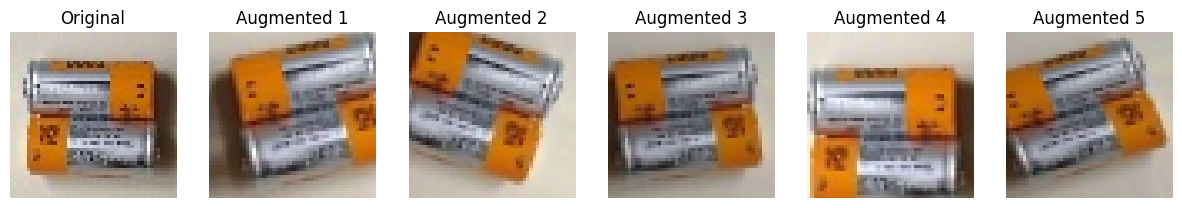

In [7]:
def plot_augmented_images(original, generator, num_images=5):
    # Plotting the original image
    fig, axes = plt.subplots(1, num_images+1, figsize=(15, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Plotting the augmented images
    for i in range(1, num_images+1):
        augmented_image = next(generator)[0]
        axes[i].imshow(augmented_image)
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')

    plt.show()

# Load an example image - adjust index as needed
example_image = cv2.imread(train_paths[0])
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
example_image_resized = cv2.resize(example_image, img_size)  # Resize and normalize

# Prepare the image for the generator (add batch dimension, as the generator expects batches)
example_image_batch = np.expand_dims(example_image_resized, axis=0)

# Create a temporary generator for this single image
temp_generator = train_datagen.flow(
    example_image_batch,
    batch_size=1
)

# Plot the comparison for 5 augmented images
plot_augmented_images(example_image_resized, temp_generator)

#### 1.4.5 No data augmentation generator

In [8]:
train_datagen_2 = ImageDataGenerator(rescale=1./255)

print("Batch size : 32")

train_generator_32_2 = train_datagen_2.flow_from_directory(
    train_dir,  # Directory containing the training images
    target_size=img_size,  # Resizes all images to the specified size
    batch_size=32,  # Number of images to include in each batch
    class_mode=label_mode  # Type of labels provided
)

Batch size : 32
Found 12412 images belonging to 12 classes.


### 1.5 Defining the input_shape

In [9]:
input_shape = example_image_resized.shape
input_shape

(50, 50, 3)

### 1.6 Weights
Compute class weights to address class imbalance, enhancing model performance in classification tasks.

In [10]:
# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight = 'balanced', # Assign weights inversely proportional to class frequencies
    classes = np.unique(train_generator_32.classes), # Unique classes in the training data
    y = train_generator_32.classes # Actual class labels of the training data
)

# The number of classes and images in each class is the same for both batches.

In [11]:
# Create a dictionary to map class indices to their respective weights
class_weights_dict = dict(enumerate(class_weights))
# Display the dictionary containing class indices and their corresponding weights
class_weights_dict

{0: 1.3681657848324515,
 1: 1.3126057529610828,
 2: 2.128257887517147,
 3: 1.4506778868630201,
 4: 0.24280125195618155,
 5: 2.0563286944996686,
 6: 1.6818428184281842,
 7: 1.2313492063492064,
 8: 1.4947013487475915,
 9: 0.6538137378845343,
 10: 1.8569718731298623,
 11: 1.668279569892473}

### 1.7 CALLBACKS

In [12]:
# Specify the directory to save the checkpoints
checkpoint_dir = "./Callbacks_50"

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

def create_model_callbacks(model_name):
    # Create a directory for the specific model's checkpoints
    model_checkpoint_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_checkpoint_dir, exist_ok=True)

    # Define callbacks for model training
    # Callback to save the best model based on validation F1 score
    cp_callback_acc = ModelCheckpoint(
        filepath=os.path.join(model_checkpoint_dir, 'best_model_acc.weights.h5'),
        save_best_only=True,       # Save only the best model
        save_weights_only=True,    # Save only the model's weights
        monitor='val_f1_score',    # Monitor validation F1 score
        mode='max',                # Set mode to maximize the F1 score
        verbose=1                  # Verbosity level (1: display messages)
    )
    
    # Callback to stop training early if validation F1 score doesn't improve
    early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',    # Monitor validation F1 score
        patience=3,                # Number of epochs with no improvement after which training will be stopped
        mode='max',                # Set mode to maximize the F1 score
        verbose=1                  # Verbosity level (1: display messages)
    )
    
    # Callback to reduce learning rate if validation F1 score doesn't improve
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_f1_score',    # Monitor validation F1 score
        factor=0.75,               # Factor by which the learning rate will be reduced
        patience=2,                # Number of epochs with no improvement after which learning rate will be reduced
        mode='min',                # Set mode to maximize the F1 score
        verbose=1,                 # Verbosity level (1: display messages)
        min_lr=0.0001              # Minimum learning rate
    )

    # Return the list of callbacks
    return [cp_callback_acc, early_stopping_callback, reduce_lr_callback]


### 1.8 Defining functions to check the model performance

#### 1.8.1 F1 Score - as I wasn't able to use Scikit-learn's F1 score function because of incompatibility with the ImageDataGenerator variables

In [13]:
# Define a custom F1 Score metric class
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        # Initialize the metric name and any additional arguments
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize variables to keep track of true positives, false positives, and false negatives
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert true and predicted labels to boolean tensors
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.greater_equal(y_pred, 0.5)  # Adjust the threshold 
        # Calculate true positives, false positives, and false negatives
        true_positive = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        false_positive = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        false_negative = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        # Update the counts of true positives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positive, self.dtype)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(false_positive, self.dtype)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negative, self.dtype)))

    def result(self):
        # Calculate precision and recall
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        # Calculate F1 score
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

    def reset_states(self):
        # Reset the counts of true positives, false positives, and false negatives to zero
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


#### 1.8.2 Plot Training History

In [16]:
# Function to plot the F1 and Loss values for both train and validation
def plot_training_history(history):
    # Convert training history to a DataFrame
    df_hist = pd.DataFrame.from_dict(history.history)
    # Add the epoch numbers to the DataFrame
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    # Create a figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha=1.0)  # Adjust legend position
    ax1.set_ylim([0, 2])  # Set y-axis limits for better visualization

    # Plot F1 score curves
    ax2 = df_hist.plot(x="Epoch", y=['f1_score', 'val_f1_score'],
                       kind="line", grid=True, legend=True,
                       ylabel="F1 Score", 
                       xlabel="Epoch", title="F1 Score curves",                  
                       color=['darkblue', 'royalblue'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)  # Adjust legend position
    ax2.set_ylim([0, 1])  # Set y-axis limits for better visualization


#### 1.8.3 Metrics

In [17]:
# Function to extract accuracy, F1 Score, and loss, from a given training history based on a specified metric (F1 as default)
def get_metrics(rec, metric='f1_score'):
    # Find the index of the best validation accuracy
    index = np.argmax(rec.history[metric])
    
    # Extract scores based on the index
    acc = rec.history["accuracy"][index]
    f1 = rec.history["f1_score"][index]
    loss = rec.history["loss"][index]
    val_acc = rec.history["val_accuracy"][index]
    val_f1 = rec.history["val_f1_score"][index]
    val_loss = rec.history["val_loss"][index]

    return acc, f1, loss, val_acc, val_f1, val_loss

### 1.9 Compile model

In [18]:
# Function to compile the model with Adam optimizer
def compile_model_adam(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

In [19]:
# Function to compile the model with SGD optimizer
def compile_model_SGD(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

### 1.10 Custom Models 

#### 1.10.1 Linear Model

In [20]:
model_linear = Sequential([
    Conv2D(32, (3, 3), activation=None, input_shape=input_shape),  # No activation
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation=None),  # No activation
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation=None),  # No activation
    MaxPooling2D(2, 2),

    Flatten(), # Flatten the output for dense layers
    Dense(512, activation=None),  # No activation

    Dense(train_generator_32.num_classes, activation='softmax') # Output layer with softmax activation
])

# Display model summary
model_linear.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,492 (4.38 MB)

 Trainable params: 1,148,492 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

##### 1.10.1.1 Applied with batch size 32 and data augmentation

In [21]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_linear")

# Compile the model with Adam optimizer
model_linear_1 = compile_model_adam(model_linear)

# Train the model with callbacks
history_linear = model_linear_1.fit(
    train_generator_32, # Training data generator on 32 batch size
    validation_data=validation_generator_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4366 - f1_score: 0.3476 - loss: 1.7514
Epoch 1: val_f1_score improved from -inf to 0.54949, saving model to ./Callbacks_50\history_linear\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.4372 - f1_score: 0.3484 - loss: 1.7493 - val_accuracy: 0.5537 - val_f1_score: 0.5495 - val_loss: 1.3841 - learning_rate: 0.0010
Epoch 2/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5415 - f1_score: 0.4874 - loss: 1.4119
Epoch 2: val_f1_score improved from 0.54949 to 0.56674, saving model to ./Callbacks_50\history_linear\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.5416 - f1_score: 0.4875 - loss: 1.4117 - val_accuracy: 0.5773 - val_f1_score: 0.5667 - val_loss: 1.3188 - learning_rate: 0.0010
Epoch 3/50
385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5563 - f1_score: 0.5189 - loss: 1.3419
Epoch 3: val_f1_score improved from 0.56674 to 0.56923, saving model t

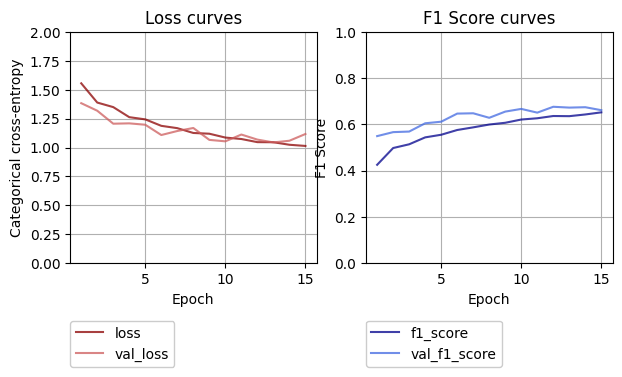

In [22]:
# Get the metrics from the history of the non-linear model
acc_linear, f1_linear, loss_linear, val_acc_linear, val_f1_linear, val_loss_linear = get_metrics(history_linear)

# Plotting the results
plot_training_history(history_linear)

#### 1.10.2 Non-Linear Model 1

In [23]:
# Define the non-linear model architecture
model_non_linear = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Convolutional layer with ReLU activation
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D(2, 2),  # Max pooling layer

    Flatten(),  # Flatten layer to convert 2D feature maps to a vector
    Dense(512, activation='relu'),  # Dense (fully connected) layer with ReLU activation

    Dense(train_generator_32.num_classes, activation='softmax') # Output layer with softmax activation
])

# Display model summary
model_non_linear.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,492 (4.38 MB)

 Trainable params: 1,148,492 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

##### 1.10.2.1 Applied with batch size 32 and data augmentation

In [24]:

# Create callbacks for the model
callbacks = create_model_callbacks("history_non_linear")

# Compile the model with Adam optimizer
model_non_linear_1 = compile_model_adam(model_non_linear)

# Train the model with callbacks
history_non_linear = model_non_linear_1.fit(
    train_generator_32, # Training data generator batch size 32
    validation_data=validation_generator_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50


385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4083 - f1_score: 0.2796 - loss: 1.7981
Epoch 1: val_f1_score improved from -inf to 0.52531, saving model to ./Callbacks_50\history_non_linear\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.4090 - f1_score: 0.2809 - loss: 1.7955 - val_accuracy: 0.5875 - val_f1_score: 0.5253 - val_loss: 1.2307 - learning_rate: 0.0010
Epoch 2/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5702 - f1_score: 0.5242 - loss: 1.2485
Epoch 2: val_f1_score improved from 0.52531 to 0.61191, saving model to ./Callbacks_50\history_non_linear\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.5703 - f1_score: 0.5244 - loss: 1.2482 - val_accuracy: 0.6294 - val_f1_score: 0.6119 - val_loss: 1.0669 - learning_rate: 0.0010
Epoch 3/50
385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6223 - f1_score: 0.5870 - loss: 1.1150
Epoch 3: val_f1_score improved from 0.61191 to 0.62916, saving

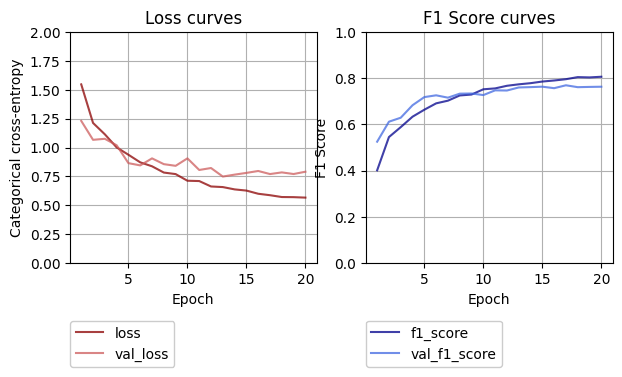

In [25]:
# Get the metrics from the history of the non-linear model
acc_non_linear, f1_non_linear, loss_non_linear, val_acc_non_linear, val_f1_non_linear, val_loss_non_linear = get_metrics(history_non_linear)

# Plotting the results
plot_training_history(history_non_linear)

##### 1.10.2.2 Applied with batch size 32 and without data augmentation

In [26]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_non_linear_2")

# Compile the model with Adam optimizer
model_non_linear_2 = compile_model_adam(model_non_linear)

# Train the model with callbacks
history_non_linear_2 = model_non_linear_2.fit(
    train_generator_32_2, # Training data generator with batch size 32
    validation_data=validation_generator_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
  7/388 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7876 - f1_score: 0.7761 - loss: 0.6708

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7923 - f1_score: 0.7912 - loss: 0.6170
Epoch 1: val_f1_score improved from -inf to 0.75814, saving model to ./Callbacks_50\history_non_linear_2\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7923 - f1_score: 0.7913 - loss: 0.6168 - val_accuracy: 0.7487 - val_f1_score: 0.7581 - val_loss: 0.7906 - learning_rate: 0.0010
Epoch 2/50
385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8388 - f1_score: 0.8331 - loss: 0.4850
Epoch 2: val_f1_score improved from 0.75814 to 0.79135, saving model to ./Callbacks_50\history_non_linear_2\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8388 - f1_score: 0.8331 - loss: 0.4851 - val_accuracy: 0.7846 - val_f1_score: 0.7913 - val_loss: 0.7166 - learning_rate: 0.0010
Epoch 3/50
385/388 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8806 - f1_score: 0.8751 - loss: 0.3632
Epoch 3: val_f1_score did not improve from 0.79135

Epoch 3:

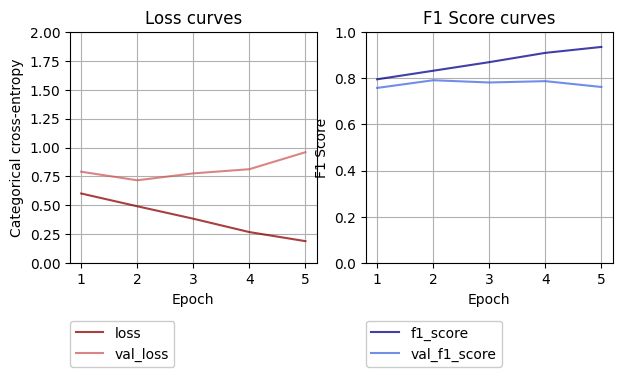

In [27]:
# Get the metrics from the history of the non-linear model
acc_non_linear_2, f1_non_linear_2, loss_non_linear_2, val_acc_non_linear_2, val_f1_non_linear_2, val_loss_non_linear_2 = get_metrics(history_non_linear_2)

# Plotting the results
plot_training_history(history_non_linear_2)

#### 1.10.3 Non-Linear Complex Model

In [28]:
model_non_linear_complex = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3), padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer

    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(1024, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Flatten(),  # Flatten layer to convert 2D feature maps to 1D feature vectors
    Dense(256, activation='relu'),  # Dense layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.2),  # Dropout layer for regularization


    Dense(train_generator_64.num_classes, activation='softmax') # Output layer with softmax activation
])

# Display model summary
model_non_linear_complex.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,562,764 (25.03 MB)

 Trainable params: 6,558,220 (25.02 MB)

 Non-trainable params: 4,544 (17.75 KB)

##### 1.10.3.1 Applied with batch size 64 and data augmentation

In [29]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_no_linear_3")
model_non_linear_3 = compile_model_adam(model_non_linear_complex)

history_non_linear_3 = model_non_linear_3.fit(
    train_generator_64,
    epochs=50,  # Set the number of epochs according to your requirement
    validation_data=validation_generator_64,
    callbacks=callbacks
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.4750 - f1_score: 0.4474 - loss: 1.7643
Epoch 1: val_f1_score improved from -inf to 0.07706, saving model to ./Callbacks_50\history_no_linear_3\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 69s 336ms/step - accuracy: 0.4753 - f1_score: 0.4477 - loss: 1.7629 - val_accuracy: 0.0693 - val_f1_score: 0.0771 - val_loss: 4.3570 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6197 - f1_score: 0.6005 - loss: 1.1863
Epoch 2: val_f1_score improved from 0.07706 to 0.42601, saving model to ./Callbacks_50\history_no_linear_3\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 67s 343ms/step - accuracy: 0.6197 - f1_score: 0.6006 - loss: 1.1861 - val_accuracy: 0.4216 - val_f1_score: 0.4260 - val_loss: 1.8634 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6653 - f1_score: 0.6521 - loss: 1.0260
Epoch 3: val_f1_score improved from 0.42601 to 0.62946,

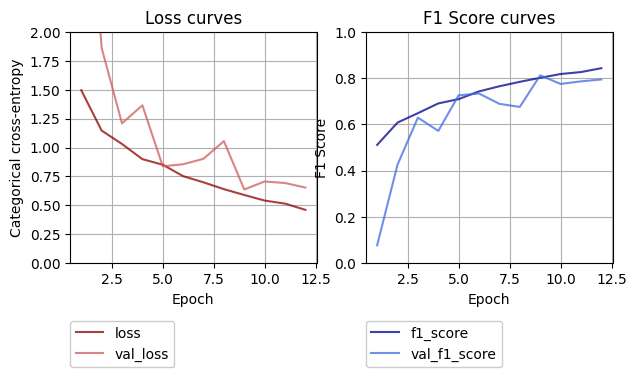

In [30]:
# Extracting evaluation metrics
acc_non_linear_3, f1_non_linear_3, loss_non_linear_3, val_acc_non_linear_3, val_f1_non_linear_3, val_loss_non_linear_3 = get_metrics(history_non_linear_3)

# Plotting the results
plot_training_history(history_non_linear_3)

#### 1.10.4 Model with more hidden units (increased dense to 256 - double)

In [31]:
model_non_linear_more_hidden = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3), padding='same'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(1024, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),  # Increase the number of hidden units to 512
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_32.num_classes, activation='softmax')
])

model_non_linear_more_hidden.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,829,260 (26.05 MB)

 Trainable params: 6,824,204 (26.03 MB)

 Non-trainable params: 5,056 (19.75 KB)

##### 1.10.4.1 Applied with batch size 32 and data augmentation

In [32]:
# Create callbacks for the model
callbacks = create_model_callbacks("history__non_linear_more_hidden")

# Compile the model with Adam optimizer
model_non_linear_4 = compile_model_adam(model_non_linear_more_hidden)

history_non_linear_4 = model_non_linear_4.fit(
    train_generator_32, # Training data generator with batch size 32
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_32, # Validation data generator
    callbacks=callbacks  # Callbacks to be applied during training
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4541 - f1_score: 0.4293 - loss: 1.8761
Epoch 1: val_f1_score improved from -inf to 0.43933, saving model to ./Callbacks_50\history__non_linear_more_hidden\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - accuracy: 0.4542 - f1_score: 0.4295 - loss: 1.8754 - val_accuracy: 0.4302 - val_f1_score: 0.4393 - val_loss: 2.1236 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5925 - f1_score: 0.5766 - loss: 1.2660
Epoch 2: val_f1_score improved from 0.43933 to 0.55928, saving model to ./Callbacks_50\history__non_linear_more_hidden\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 70s 181ms/step - accuracy: 0.5925 - f1_score: 0.5766 - loss: 1.2659 - val_accuracy: 0.5644 - val_f1_score: 0.5593 - val_loss: 1.3427 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6207 - f1_score: 0.6117 - loss: 1.1407
Epoch 3: val_f1_scor

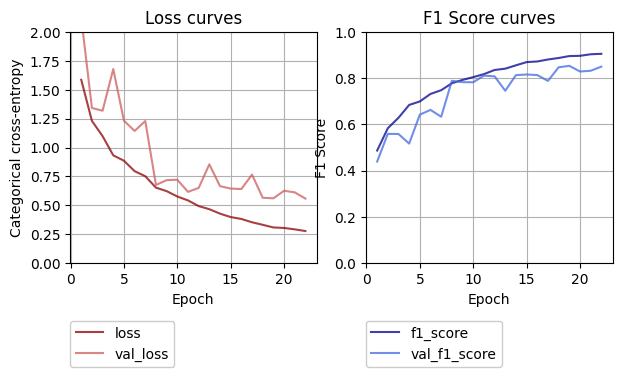

In [33]:
# Extracting evaluation metrics
acc_non_linear_4, f1_non_linear_4, loss_non_linear_4, val_acc_non_linear_4, val_f1_non_linear_4, val_loss_non_linear_4 = get_metrics(history_non_linear_4)

# Plotting the results
plot_training_history(history_non_linear_4)

In [34]:
data_50 = {
    "Model": ["model_linear", "model_non_linear_1", "model_non_linear_2", "model_non_linear_3", "model_non_linear_4"],  
    "Accuracy": [acc_linear, acc_non_linear, acc_non_linear_2, acc_non_linear_3, acc_non_linear_4],  
    "F1_Score": [f1_linear, f1_non_linear, f1_non_linear_2, f1_non_linear_3, f1_non_linear_4],  
    "Loss": [loss_linear, loss_non_linear, loss_non_linear_2, loss_non_linear_3, loss_non_linear_4],  
    "Val_Accuracy": [val_acc_linear, val_acc_non_linear, val_acc_non_linear_2, val_acc_non_linear_3, val_acc_non_linear_4],  
    "Val_F1_Score": [val_f1_linear, val_f1_non_linear, val_f1_non_linear_2, val_f1_non_linear_3, val_f1_non_linear_4],  
    "Val_Loss": [val_loss_linear, val_loss_non_linear, val_loss_non_linear_2, val_loss_non_linear_3, val_loss_non_linear_4]
}


print(pd.DataFrame(data_50))

                Model  Accuracy  F1_Score      Loss  Val_Accuracy  \
0        model_linear  0.672414  0.652419  1.013973      0.657358   
1  model_non_linear_1  0.810103  0.806509  0.566542      0.752954   
2  model_non_linear_2  0.935627  0.935568  0.189619      0.758324   
3  model_non_linear_3  0.844747  0.843429  0.460607      0.794307   
4  model_non_linear_4  0.905897  0.905786  0.277223      0.844791   

   Val_F1_Score  Val_Loss  
0      0.661760  1.117256  
1      0.763293  0.790725  
2      0.762222  0.959692  
3      0.794755  0.653408  
4      0.850247  0.558161  


### 1.11 Pre trained/famous models 

#### 1.11.1 VGGNET_16

In [37]:
def vgg_block(input_tensor, num_conv_layers, num_filters):
    x = input_tensor
    for _ in range(num_conv_layers):
        x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)  # Adjust pooling size and stride
    return x

def VGGNet_16(input_shape=img_size, num_classes=12):
    inputs = layers.Input(shape=input_shape)
    
    x = vgg_block(inputs, 2, 16)  # Decrease number of filters
    x = vgg_block(x, 2, 32) 
    x = vgg_block(x, 2, 64) 
    x = vgg_block(x, 1, 128)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)  # Reduce number of units
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Instantiate the updated VGGNet model
vggnet_16_model = VGGNet_16(input_shape, 12)

# Display updated model summary
vggnet_16_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 50, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,148 (832.61 KB)

 Trainable params: 213,148 (832.61 KB)

 Non-trainable params: 0 (0.00 B)

##### 1.11.1.1 Apply with batch size 32 and data augmentation

In [38]:
# Compile the model
vggnet_16_model_32 = compile_model_adam(vggnet_16_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_vggnet_16_model_32")

# Train the model
history_vggnet_16_batch_32 = vggnet_16_model_32.fit(
    train_generator_32, # Training data generator with batch size 32
    validation_data=validation_generator_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3506 - f1_score: 0.2037 - loss: 2.0462
Epoch 1: val_f1_score improved from -inf to 0.42779, saving model to ./Callbacks_50\history_vggnet_16_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.3509 - f1_score: 0.2045 - loss: 2.0448 - val_accuracy: 0.4769 - val_f1_score: 0.4278 - val_loss: 1.5084 - learning_rate: 0.0010
Epoch 2/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4849 - f1_score: 0.4357 - loss: 1.5063
Epoch 2: val_f1_score improved from 0.42779 to 0.49648, saving model to ./Callbacks_50\history_vggnet_16_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.4851 - f1_score: 0.4358 - loss: 1.5060 - val_accuracy: 0.5736 - val_f1_score: 0.4965 - val_loss: 1.2843 - learning_rate: 0.0010
Epoch 3/50
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5418 - f1_score: 0.4900 - loss: 1.3391
Epoch 3: val_f1_score improved from

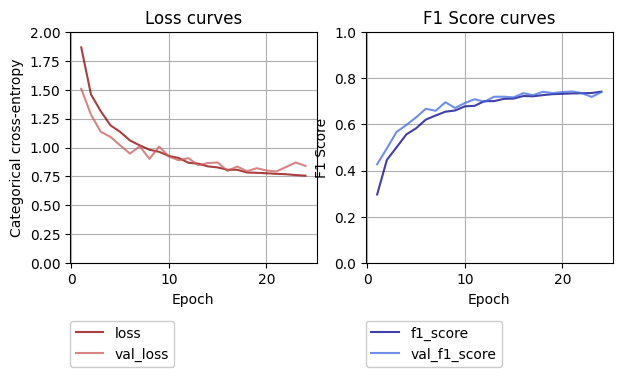

In [39]:
# Extracting evaluation metrics
acc_vggnet_16_batch_32, f1_vggnet_16_batch_32, loss_vggnet_16_batch_32, val_acc_vggnet_16_batch_32, val_f1_vggnet_16_batch_32, val_loss_vggnet_16_batch_32 = get_metrics(history_vggnet_16_batch_32)

# Plotting the results
plot_training_history(history_vggnet_16_batch_32)

#### 1.11.2 VGG NET 19

In [46]:
def vgg_block(input_tensor, num_conv_layers, num_filters):
    x = input_tensor
    for _ in range(num_conv_layers):
        x = layers.Conv2D(num_filters, (4, 4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((4, 4), strides=(3, 3))(x)
    return x

def VGG_19(input_shape=img_size, num_classes=12):
    inputs = layers.Input(shape=input_shape)
    
    x = vgg_block(inputs, 1, 64)
    x = vgg_block(x, 2, 128)
    x = vgg_block(x, 1, 256) 

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Instantiate the VGG19 model
vgg_19_model = VGG_19(input_shape, 12)

# Display model summary
vgg_19_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 50, 50, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 5, 5, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,148 (4.53 MB)

 Trainable params: 1,187,148 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

##### 1.11.2.1 Apply with batch size 32 and data augmentation

In [47]:
# Compile the model
vgg_19_model_32 = compile_model_adam(vgg_19_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_vggnet_19_model_32")

# Train the model
history_vggnet_19_batch_32 = vgg_19_model_32.fit(
    train_generator_32, # Training data generator with batch size 32
    validation_data=validation_generator_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3713 - f1_score: 0.2323 - loss: 1.9913
Epoch 1: val_f1_score improved from -inf to 0.50715, saving model to ./Callbacks_50\history_vggnet_19_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.3715 - f1_score: 0.2328 - loss: 1.9900 - val_accuracy: 0.5644 - val_f1_score: 0.5071 - val_loss: 1.2814 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5337 - f1_score: 0.4819 - loss: 1.3619
Epoch 2: val_f1_score improved from 0.50715 to 0.57512, saving model to ./Callbacks_50\history_vggnet_19_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.5337 - f1_score: 0.4820 - loss: 1.3619 - val_accuracy: 0.6026 - val_f1_score: 0.5751 - val_loss: 1.1770 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5732 - f1_score: 0.5397 - loss: 1.2373
Epoch 3: val_f1_score improved from

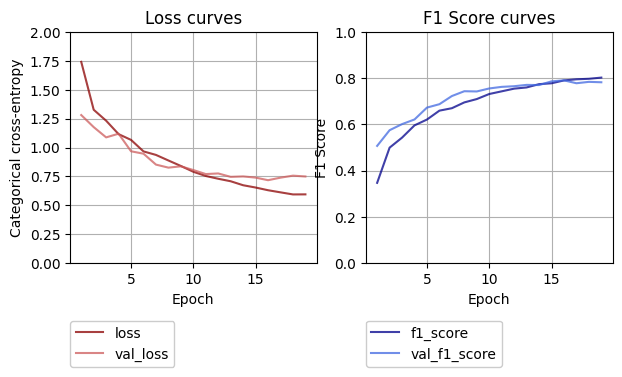

In [48]:
# Extracting evaluation metrics
acc_vggnet_19_batch_32, f1_vggnet_19_batch_32, loss_vggnet_19_batch_32, val_acc_vggnet_19_batch_32, val_f1_vggnet_19_batch_32, val_loss_vggnet_19_batch_32 = get_metrics(history_vggnet_19_batch_32)

# Plotting the results
plot_training_history(history_vggnet_19_batch_32)

In [49]:
data_pre_trained_50 = {
    "Model": ["VGG19", "VGG16"],  # Updated model names
    "Accuracy": [acc_vggnet_19_batch_32, acc_vggnet_16_batch_32],  # Updated accuracy values
    "F1_Score": [f1_vggnet_19_batch_32,  f1_vggnet_16_batch_32],  # Updated F1 score values
    "Loss": [loss_vggnet_19_batch_32, loss_vggnet_16_batch_32],  # Updated loss values
    "Val_Accuracy": [val_acc_vggnet_19_batch_32, val_acc_vggnet_16_batch_32],  # Updated validation accuracy values
    "Val_F1_Score": [val_f1_vggnet_19_batch_32, val_f1_vggnet_16_batch_32],  # Updated validation F1 score values
    "Val_Loss": [val_loss_vggnet_19_batch_32, val_loss_vggnet_16_batch_32]  # Updated validation loss values
}


print(pd.DataFrame(data_pre_trained_50))

   Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  VGG19  0.805591  0.802759  0.594644      0.773362      0.782609  0.749524
1  VGG16  0.745891  0.741950  0.756563      0.736305      0.739878  0.841008


## 2. Size 128x128 pixels 

### 2.1 Import the splited data

In [50]:
# Function to load images data and corresponding labels from a directory
def load_data_from_directory(directory):
    # Lists to store the file paths as well as the labels of the images
    file_paths = []
    class_labels = []
    # Walk through the directory
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        # Make sure to ignore any non-directory entries
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                # Check if the file is a JPEG image
                if filename.endswith('.jpg'):
                    file_paths.append(file_path)
                    class_labels.append(class_name)
    # Convert class labels to numeric
    unique_classes = np.unique(class_labels)
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
    numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]
    return file_paths, numeric_labels, class_to_idx

# Define directories
split_dir_128 = "./train_test_val_128"
train_dir_128 = os.path.join(split_dir_128, 'train')
test_dir_128 = os.path.join(split_dir_128, 'test')
val_dir_128 = os.path.join(split_dir_128, 'validation')

# Load data
train_paths_128, train_labels_128, class_to_idx = load_data_from_directory(train_dir_128)
test_paths_128, test_labels_128, _ = load_data_from_directory(test_dir_128)
val_paths_128, val_labels_128, _ = load_data_from_directory(val_dir_128)

# Verify the data
print(f"Loaded {len(train_paths_128)} training samples.")
print(f"Loaded {len(test_paths_128)} testing samples.")
print(f"Loaded {len(val_paths_128)} validation samples.")

Loaded 12412 training samples.
Loaded 1241 testing samples.
Loaded 1862 validation samples.


### 2.2 Defining needed variables

In [51]:
# Define the image size for resizing
img_size_128 = (128,128)

### 2.3 Data Augmentation

I'm implementing data augmentation in the training dataset so that the model can see different images produced from the original one across epochs. I'm also resizing images so that the pixel values range from 0 to 1.

When I create the train_generator using flow_from_dataframe, I'm not pre-generating all batches of images with their transformations. What I'm doing is setting up a framework or a "pipeline" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images on-the-fly during each step of each epoch. It doesn't pre-generate and store them..

#### 2.3.1 Image Data Generator Configuration

In [58]:

# Define the ImageDataGenerator for training with augmentation
train_datagen_128 = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=45,       # Randomly rotate images in the range (0, 45 degrees)
    width_shift_range=0.1,   # Randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # Randomly shift images vertically (10% of total height)
    shear_range=0.1,         # Apply shear transformations
    zoom_range=0.2,          # Randomly zoom image in and out (20% zoom)
    horizontal_flip=True,    # Randomly flip images horizontally
    brightness_range=[0.8, 1.2], # Randomly change brightness (80-120% of original value)
    fill_mode='nearest'      # Fill in new pixels after a transformation
)

   
# For validation, typically no augmentation is applied, just rescaling
val_datagen_128 = ImageDataGenerator(rescale=1./255)

As I observed poorer performance with a batch size of 16 in the previous notebooks, I have opted not to use this size.
As I observed overfitting with a batch size of 128 in the previous notebooks, I have opted not to use this size.

##### 2.3.1.1 Applying the generator for a batch size of 32

In [59]:
# Generate batches of augmented training data from the directory
train_generator_128_32 = train_datagen.flow_from_directory(
    train_dir_128,
    target_size=img_size_128,  # Ensure all images are resized to 50x50
    batch_size=32,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)

# Generate batches of validation data from the directory
validation_generator_128_32 = val_datagen_128.flow_from_directory(
    val_dir_128,  # Directory containing the validation images
    target_size=img_size_128,  # Resize images to the specified dimensions
    batch_size=32,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


##### 2.3.1.2 Applying the generator for a batch size of 64

In [60]:
# Generate batches of augmented training data from the directory
train_generator_128_64 = train_datagen.flow_from_directory(
    train_dir_128,
    target_size=img_size_128,  # Ensure all images are resized to 50x50
    batch_size=64,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)


# Generate batches of validation data from the directory
validation_generator_128_64 = val_datagen_128.flow_from_directory(
    val_dir_128,  # Directory containing the validation images
    target_size=img_size_128,  # Ensure all images are resized to 50x50
    batch_size=64,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


#### 2.3.2 Show some example of augmented transformation in images

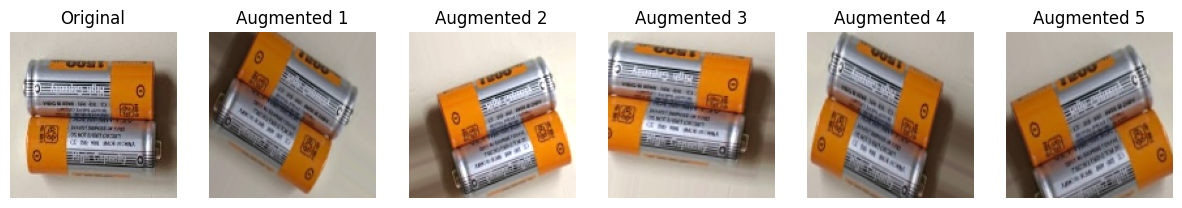

In [61]:
def plot_augmented_images(original, generator, num_images=5):
    # Plotting the original image
    fig, axes = plt.subplots(1, num_images+1, figsize=(15, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Plotting the augmented images
    for i in range(1, num_images+1):
        augmented_image = next(generator)[0]
        axes[i].imshow(augmented_image)
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')

    plt.show()

# Load an example image - adjust index as needed
example_image_128 = cv2.imread(train_paths_128[0])
example_image_128 = cv2.cvtColor(example_image_128, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
example_image_resized_128 = cv2.resize(example_image_128, img_size_128)  # Resize and normalize

# Prepare the image for the generator (add batch dimension, as the generator expects batches)
example_image_batch_128 = np.expand_dims(example_image_resized_128, axis=0)

# Create a temporary generator for this single image
temp_generator_128 = train_datagen_128.flow(
    example_image_batch_128,
    batch_size=1
)

# Plot the comparison for 5 augmented images
plot_augmented_images(example_image_resized_128, temp_generator_128)

### 2.3.3 No data augmented generator

In [62]:
train_datagen_128_3 = ImageDataGenerator(rescale=1./255)

print("Batch size : 32")

train_datagen_128_32_3 = train_datagen_128_3.flow_from_directory(
    train_dir_128, # Directory containing the training images
    target_size=img_size_128, # Resize images to the specified dimensions
    batch_size=32, # Number of images to return in each batch
    class_mode=label_mode  # Type of labels provided
)

Batch size : 32
Found 12412 images belonging to 12 classes.


### 2.4 Defining the input_shape

In [63]:
input_shape_128 = example_image_resized_128.shape
input_shape_128

(128, 128, 3)

### 2.5 CALLBACKS

In [64]:
# Specify the directory to save the checkpoints
checkpoint_dir_128 = "./Callbacks_128"

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir_128, exist_ok=True)

def create_model_callbacks(model_name):
    # Create a directory for the specific model's checkpoints
    model_checkpoint_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_checkpoint_dir, exist_ok=True)

    # Define callbacks for model training
    # Callback to save the best model based on validation F1 score
    cp_callback_acc = ModelCheckpoint(
        filepath=os.path.join(model_checkpoint_dir, 'best_model_acc.weights.h5'),
        save_best_only=True,       # Save only the best model
        save_weights_only=True,    # Save only the model's weights
        monitor='val_f1_score',    # Monitor validation F1 score
        mode='max',                # Set mode to maximize the F1 score
        verbose=1                  # Verbosity level (1: display messages)
    )
    
    # Callback to stop training early if validation F1 score doesn't improve
    early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',    # Monitor validation F1 score
        patience=3,                # Number of epochs with no improvement after which training will be stopped
        mode='max',                # Set mode to maximize the F1 score
        verbose=1                  # Verbosity level (1: display messages)
    )
    
    # Callback to reduce learning rate if validation F1 score doesn't improve
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_f1_score',    # Monitor validation F1 score
        factor=0.75,               # Factor by which the learning rate will be reduced
        patience=2,                # Number of epochs with no improvement after which learning rate will be reduced
        mode='min',                # Set mode to maximize the F1 score
        verbose=1,                 # Verbosity level (1: display messages)
        min_lr=0.0001              # Minimum learning rate
    )

    # Return the list of callbacks
    return [cp_callback_acc, early_stopping_callback, reduce_lr_callback]


### 2.6 Custom Models

#### 2.6.1 Linear Model

In [67]:
model_linear_128 = Sequential([
    Conv2D(32, (3, 3), activation=None, input_shape=input_shape_128),  # No activation
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation=None),  # No activation
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation=None),  # No activation
    MaxPooling2D(2, 2),

    Flatten(), # Flatten the output for dense layers
    Dense(512, activation=None),  # No activation

    Dense(train_generator_128_32.num_classes, activation='softmax') # Output layer with softmax activation
])

# Display model summary
model_linear_128.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,944,972 (49.38 MB)

 Trainable params: 12,944,972 (49.38 MB)

 Non-trainable params: 0 (0.00 B)

##### 2.6.1.1 Aplly with batch size 32 and data augmentation

In [68]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_linear_128")

# Compile the model with Adam optimizer
model_linear_128_1 = compile_model_adam(model_linear_128)

# Train the model with callbacks
history_linear_128 = model_linear_128_1.fit(
    train_generator_128_32, # Training data generator with 32 batch size
    validation_data=validation_generator_128_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.4196 - f1_score: 0.3831 - loss: 3.0062
Epoch 1: val_f1_score improved from -inf to 0.50018, saving model to ./Callbacks_50\history_linear_128\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 84s 211ms/step - accuracy: 0.4197 - f1_score: 0.3832 - loss: 3.0033 - val_accuracy: 0.5478 - val_f1_score: 0.5002 - val_loss: 1.4426 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5381 - f1_score: 0.5043 - loss: 1.4405
Epoch 2: val_f1_score improved from 0.50018 to 0.56935, saving model to ./Callbacks_50\history_linear_128\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 76s 195ms/step - accuracy: 0.5381 - f1_score: 0.5043 - loss: 1.4405 - val_accuracy: 0.5843 - val_f1_score: 0.5694 - val_loss: 1.2843 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5453 - f1_score: 0.5082 - loss: 1.3985
Epoch 3: val_f1_score did not improve from 0.56935

Epoch

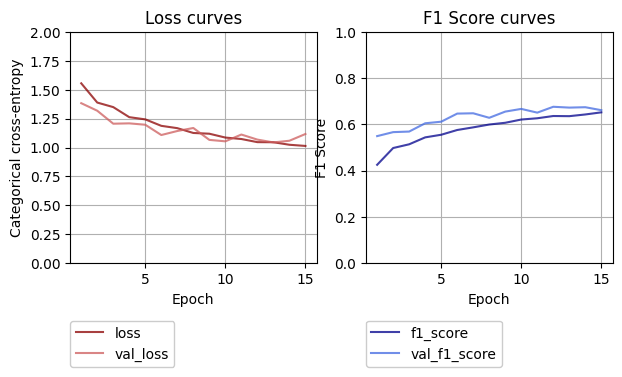

In [69]:
# Get metrics from the training history
acc_linear_128, f1_linear_128, loss_linear_128, val_acc_linear_128, val_f1_linear_128, val_loss_linear_128 = get_metrics(history_linear_128)

# Plotting the results
plot_training_history(history_linear)

#### 2.6.2 Non Linear Model 1

In [70]:
# Define the non-linear model architecture
model_non_linear_128 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_128),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),

    Dense(train_generator_128_32.num_classes, activation='softmax')
])

# Display model summary
model_non_linear_128.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,944,972 (49.38 MB)

 Trainable params: 12,944,972 (49.38 MB)

 Non-trainable params: 0 (0.00 B)

##### 2.6.2.1 apply with a batch size of 32 and data augmentation

In [71]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_non_linear_128")

# Compile the model with Adam optimizer
model_non_linear_128_1 = compile_model_adam(model_non_linear_128)

# Train the model with callbacks
history_non_linear_128 = model_non_linear_128_1.fit(
    train_generator_128_32, # Training data generator with batch size 32
    validation_data=validation_generator_128_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4191 - f1_score: 0.3172 - loss: 1.8315
Epoch 1: val_f1_score improved from -inf to 0.59488, saving model to ./Callbacks_50\history_non_linear_128\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 88s 221ms/step - accuracy: 0.4193 - f1_score: 0.3175 - loss: 1.8306 - val_accuracy: 0.6020 - val_f1_score: 0.5949 - val_loss: 1.2170 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5942 - f1_score: 0.5609 - loss: 1.1943
Epoch 2: val_f1_score improved from 0.59488 to 0.65331, saving model to ./Callbacks_50\history_non_linear_128\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.5942 - f1_score: 0.5610 - loss: 1.1942 - val_accuracy: 0.6595 - val_f1_score: 0.6533 - val_loss: 1.0188 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6403 - f1_score: 0.6150 - loss: 1.0484
Epoch 3: val_f1_score improved from 0.

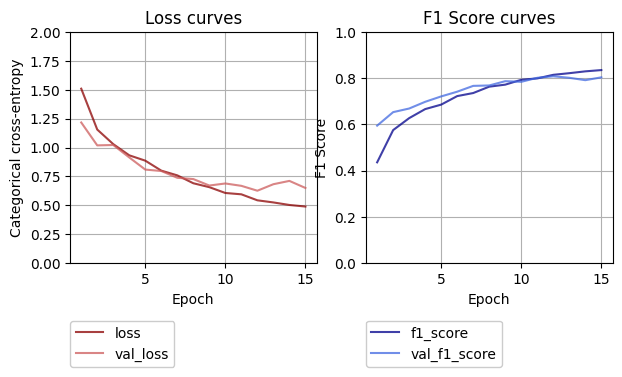

In [72]:
# Get the metrics from the history of the non-linear model
acc_non_linear_128, f1_non_linear_128, loss_non_linear_128, val_acc_non_linear_128, val_f1_non_linear_128, val_loss_non_linear_128 = get_metrics(history_non_linear_128)

# Plotting the results
plot_training_history(history_non_linear_128)

##### 2.6.2.2 Apply with batch size 32 and no data augmentation

In [73]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_non_linear_128_2")

# Compile the model with Adam optimizer
model_non_linear_128_2 = compile_model_adam(model_non_linear_128)

# Train the model with callbacks
history_non_linear_128_2 = model_non_linear_128_2.fit(
    train_datagen_128_32_3, # Training data generator with batch size 32 and no data augmentation
    validation_data=validation_generator_128_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8209 - f1_score: 0.8214 - loss: 0.5251
Epoch 1: val_f1_score improved from -inf to 0.80023, saving model to ./Callbacks_50\history_non_linear_128_2\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 61s 154ms/step - accuracy: 0.8209 - f1_score: 0.8214 - loss: 0.5251 - val_accuracy: 0.7997 - val_f1_score: 0.8002 - val_loss: 0.6042 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9028 - f1_score: 0.9012 - loss: 0.3002
Epoch 2: val_f1_score improved from 0.80023 to 0.81343, saving model to ./Callbacks_50\history_non_linear_128_2\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 58s 150ms/step - accuracy: 0.9028 - f1_score: 0.9011 - loss: 0.3002 - val_accuracy: 0.8131 - val_f1_score: 0.8134 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9425 - f1_score: 0.9428 - loss: 0.1697
Epoch 3: val_f1_score did not improve from 0.

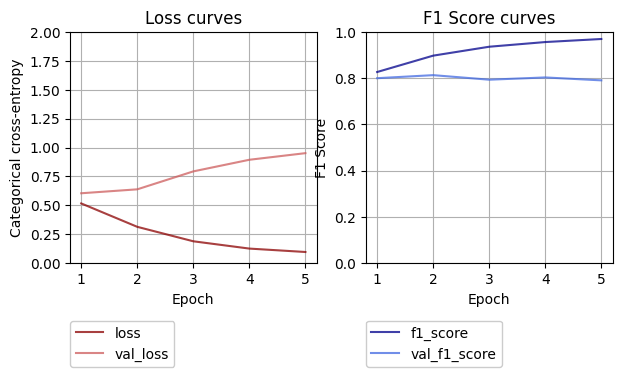

In [74]:
# Get the metrics from the history of the non-linear model
acc_non_linear_128_2, f1_non_linear_128_2, loss_non_linear_128_2, val_acc_non_linear_128_2, val_f1_non_linear_128_2, val_loss_non_linear_128_2 = get_metrics(history_non_linear_128_2)

# Plotting the results
plot_training_history(history_non_linear_128_2)

#### 2.6.3 Model Non-Linear More Complex

In [75]:
# Define the architecture of the model
model_non_linear_complex_128 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_128, padding='same'), # Convolutional layer with ReLU activation
    BatchNormalization(), # Batch normalization layer

    Conv2D(64, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(128, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(256, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(512, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(1024, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Flatten(),  # Flatten layer to convert 2D feature maps to 1D feature vectors
    Dense(256, activation='relu'),  # Dense layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.2),  # Dropout layer for regularization

    Dense(train_generator_128_64.num_classes, activation='softmax') # Output layer with softmax activation
])

# Display model summary
model_non_linear_complex_128.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,494,924 (40.03 MB)

 Trainable params: 10,490,380 (40.02 MB)

 Non-trainable params: 4,544 (17.75 KB)

##### 2.6.3.1 Apply with batch size 64 and data augmentation

In [76]:
# Create callbacks for the model
callbacks = create_model_callbacks("history_no_linear_128_3")

# Compile the model with adam optimizer
model_non_linear_128_3 = compile_model_adam(model_non_linear_complex_128)

history_non_linear_128_3 = model_non_linear_128_3.fit(
    train_generator_128_64, # Training data generator 64 batch size
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_128_64,  # Validation data generator
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4792 - f1_score: 0.4614 - loss: 1.7873
Epoch 1: val_f1_score improved from -inf to 0.04332, saving model to ./Callbacks_50\history_no_linear_128_3\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.4796 - f1_score: 0.4618 - loss: 1.7856 - val_accuracy: 0.0505 - val_f1_score: 0.0433 - val_loss: 6.8336 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6367 - f1_score: 0.6211 - loss: 1.1223
Epoch 2: val_f1_score improved from 0.04332 to 0.42463, saving model to ./Callbacks_50\history_no_linear_128_3\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.6367 - f1_score: 0.6211 - loss: 1.1223 - val_accuracy: 0.4066 - val_f1_score: 0.4246 - val_loss: 2.1502 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6689 - f1_score: 0.6544 - loss: 1.0067
Epoch 3: val_f1_score improved from 0.42463 to 0.55313, savi

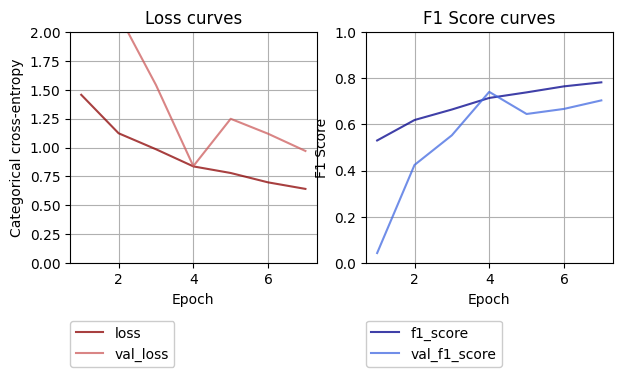

In [77]:
# Extracting evaluation metrics
acc_non_linear_128_3, f1_non_linear_128_3, loss_non_linear_128_3, val_acc_non_linear_128_3, val_f1_non_linear_128_3, val_loss_non_linear_128_3 = get_metrics(history_non_linear_128_3)

# Plotting the results
plot_training_history(history_non_linear_128_3)

####  2.6.4 Model Non-Linear With more units

In [78]:
# Model definition with increased complexity and batch normalization
model_non_linear_more_hidden_128 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_128, padding='same'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(1024, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'), # Increase the number of hidden units to 512 
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_128_32.num_classes, activation='softmax')
])

# Display model summary
model_non_linear_more_hidden_128.summary()

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,693,580 (56.05 MB)

 Trainable params: 14,688,524 (56.03 MB)

 Non-trainable params: 5,056 (19.75 KB)

##### 2.6.4.1 Apply with batch size 32 and data augmentation

In [79]:
# Create callbacks for the model
callbacks = create_model_callbacks("history__non_linear_more_hidden_128")

# Compile the model with Adam optimizer
model_non_linear_128_4 = compile_model_adam(model_non_linear_more_hidden_128)

history_non_linear_128_4 = model_non_linear_128_4.fit(
    train_generator_128_32, # Training data generator with batch size 32
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator_128_32, # Validation data generator
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4626 - f1_score: 0.4435 - loss: 1.8972
Epoch 1: val_f1_score improved from -inf to 0.47661, saving model to ./Callbacks_50\history__non_linear_more_hidden_128\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.4627 - f1_score: 0.4436 - loss: 1.8963 - val_accuracy: 0.4774 - val_f1_score: 0.4766 - val_loss: 1.6591 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6052 - f1_score: 0.5899 - loss: 1.2309
Epoch 2: val_f1_score improved from 0.47661 to 0.48344, saving model to ./Callbacks_50\history__non_linear_more_hidden_128\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.6052 - f1_score: 0.5899 - loss: 1.2308 - val_accuracy: 0.4764 - val_f1_score: 0.4834 - val_loss: 1.8116 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6585 - f1_score: 0.6468 - loss: 1.0381
Epoch 3: val_f1_score imp

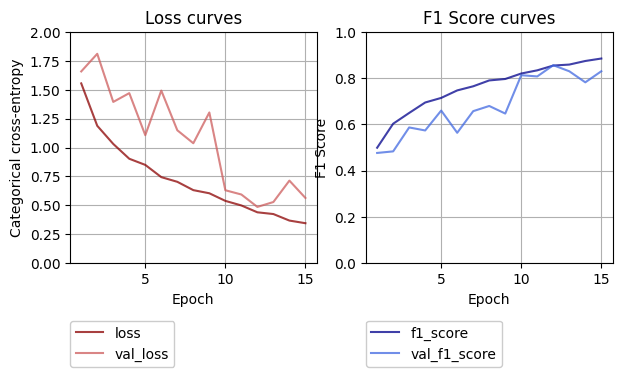

In [80]:
# Extracting evaluation metrics
acc_non_linear_128_4, f1_non_linear_128_4, loss_non_linear_128_4, val_acc_non_linear_128_4, val_f1_non_linear_128_4, val_loss_non_linear_128_4 = get_metrics(history_non_linear_128_4)

# Plotting the results
plot_training_history(history_non_linear_128_4)

In [81]:
data_128 = {
    "Model": ["model_linear_128", "model_non_linear_128_1", "model_non_linear_128_2", "model_non_linear_128_3", "model_non_linear_128_4"],  
    "Accuracy": [acc_linear_128, acc_non_linear_128, acc_non_linear_128_2, acc_non_linear_128_3, acc_non_linear_128_4],  
    "F1_Score": [f1_linear_128, f1_non_linear_128, f1_non_linear_128_2, f1_non_linear_128_3, f1_non_linear_128_4],  
    "Loss": [loss_linear_128, loss_non_linear_128, loss_non_linear_128_2, loss_non_linear_128_3, loss_non_linear_128_4],  
    "Val_Accuracy": [val_acc_linear_128, val_acc_non_linear_128, val_acc_non_linear_128_2, val_acc_non_linear_128_3, val_acc_non_linear_128_4],  
    "Val_F1_Score": [val_f1_linear_128, val_f1_non_linear_128, val_f1_non_linear_128_2, val_f1_non_linear_128_3, val_f1_non_linear_128_4],  
    "Val_Loss": [val_loss_linear_128, val_loss_non_linear_128, val_loss_non_linear_128_2, val_loss_non_linear_128_3, val_loss_non_linear_128_4]
}

# Print the updated data3
print(pd.DataFrame(data_128))

                    Model  Accuracy  F1_Score      Loss  Val_Accuracy  \
0        model_linear_128  0.612794  0.579903  1.214179      0.612782   
1  model_non_linear_128_1  0.832501  0.835342  0.489316      0.798604   
2  model_non_linear_128_2  0.969948  0.969930  0.095729      0.788937   
3  model_non_linear_128_3  0.786175  0.782303  0.642038      0.694415   
4  model_non_linear_128_4  0.885595  0.885408  0.344950      0.818475   

   Val_F1_Score  Val_Loss  
0      0.594170  1.234785  
1      0.803844  0.650221  
2      0.790850  0.951433  
3      0.704124  0.970547  
4      0.830262  0.563699  


### 2.7 Pre trained and famous models 

#### 2.7.1 DenseNet_169

In [82]:
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(growth_rate, 3, padding='same')(x1)
        x = layers.Concatenate()([x, x1])
    return x

def transition_layer(x, compression_factor):
    num_filters = int(x.shape[-1] * compression_factor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 1, padding='same')(x)
    x = layers.AveragePooling2D(2, strides=2)(x)
    return x

def DenseNet_169(input_shape=img_size, num_classes=12):
    inputs = layers.Input(shape=input_shape)

    # Ensure that the input shape includes the channel dimension
    if len(input_shape) == 2:
        inputs = layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    blocks = [6, 9, 15]  # Adjusted number of layers per block for DenseNet-169

    for i, num_layers in enumerate(blocks):
        x = dense_block(x, num_layers, 32)
        if i < len(blocks) - 1:
            x = transition_layer(x, 0.5)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Instantiate the DenseNet-169 model
densenet_169_model = DenseNet_169(input_shape=(128,128,3), num_classes=12)

# Display model summary
densenet_169_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 64, 64,    │      9,472 │ input_layer_14[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ max_pooling2d_52… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 32, 32,    │     18,464 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ max_pooling2d_52… │
│ (Concatenate)       │ 96)               │            │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32,    │     27,680 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 128)              │            │ conv2d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 32,    │     36,896 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ concatenate_1[0]

 Total params: 2,958,492 (11.29 MB)

 Trainable params: 2,937,724 (11.21 MB)

 Non-trainable params: 20,768 (81.12 KB)

##### 2.7.1.1 Apply with batch size 64 and data augmentation

In [84]:
# Compile the model
densenet_169_model_64 = compile_model_adam(densenet_169_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_densenet_169_model_64")

# Train the model
history_densenet_169_model_batch_64 = densenet_169_model_64.fit(
    train_generator_128_64, # Training data generator with batch size 64
    validation_data=validation_generator_128_64, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3946 - f1_score: 0.3446 - loss: 2.9888
Epoch 1: val_f1_score improved from -inf to 0.10135, saving model to ./Callbacks_50\history_densenet_169_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.3949 - f1_score: 0.3449 - loss: 2.9842 - val_accuracy: 0.1235 - val_f1_score: 0.1014 - val_loss: 3.0932 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5019 - f1_score: 0.4427 - loss: 1.5980
Epoch 2: val_f1_score improved from 0.10135 to 0.51771, saving model to ./Callbacks_50\history_densenet_169_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.5020 - f1_score: 0.4428 - loss: 1.5976 - val_accuracy: 0.5317 - val_f1_score: 0.5177 - val_loss: 1.3951 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5506 - f1_score: 0.5073 - loss: 1.3628
Epoch 3: val_f1_score did not improve

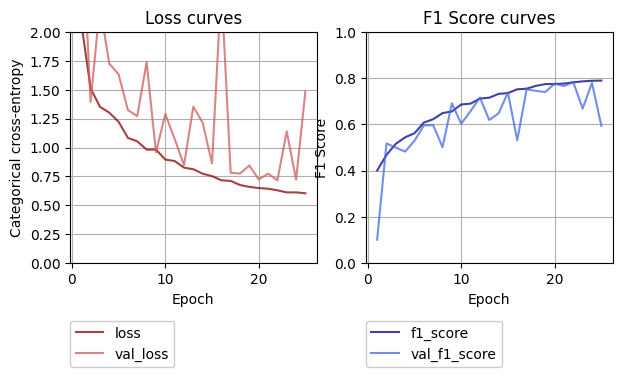

In [85]:
# Extracting evaluation metrics
acc_dense_net_169_64, f1_dense_net_169_64, loss_dense_net_169_64, val_acc_dense_net_169_64, val_f1_dense_net_169_64, val_loss_dense_net_169_64 = get_metrics(history_densenet_169_model_batch_64)

# Plotting the results
plot_training_history(history_densenet_169_model_batch_64)

#### 2.7.2 VGGNET_19

In [86]:
def vgg_block(input_tensor, num_conv_layers, num_filters):
    x = input_tensor
    for _ in range(num_conv_layers):
        x = layers.Conv2D(num_filters, (4, 4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((5, 5), strides=(3, 3))(x)
    return x

def VGG_19(input_shape=img_size_128, num_classes=12):
    inputs = layers.Input(shape=input_shape)
    
    x = vgg_block(inputs, 1, 64)
    x = vgg_block(x, 2, 128)
    x = vgg_block(x, 1, 256) 

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Instantiate the VGG19 model
vgg_19_model_128 = VGG_19(input_shape_128, 12)

# Display model summary
vgg_19_model_128.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 42, 42, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 42, 42, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 13, 13, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,235,724 (8.53 MB)

 Trainable params: 2,235,724 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

##### 2.7.2.1 Apply with batch size 32 and data augmentation

In [87]:
# Compile the model
vgg_19_model_128_32 = compile_model_adam(vgg_19_model_128)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_vggnet_19_model_128_32")

# Train the model
history_vggnet_19_128_32 = vgg_19_model_128_32.fit(
    train_generator_128_32, # Training data generator with batch size 32
    validation_data=validation_generator_128_32, # Validation data generator
    epochs=50, # Number of epochs for training
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3387 - f1_score: 0.1672 - loss: 2.1294
Epoch 1: val_f1_score improved from -inf to 0.48315, saving model to ./Callbacks_50\history_vggnet_19_model_128_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 128s 325ms/step - accuracy: 0.3389 - f1_score: 0.1675 - loss: 2.1286 - val_accuracy: 0.5489 - val_f1_score: 0.4831 - val_loss: 1.3451 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5295 - f1_score: 0.4760 - loss: 1.4115
Epoch 2: val_f1_score improved from 0.48315 to 0.54609, saving model to ./Callbacks_50\history_vggnet_19_model_128_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 127s 325ms/step - accuracy: 0.5296 - f1_score: 0.4761 - loss: 1.4113 - val_accuracy: 0.6090 - val_f1_score: 0.5461 - val_loss: 1.1936 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5748 - f1_score: 0.5359 - loss: 1.2368
Epoch 3: val_f1_scor

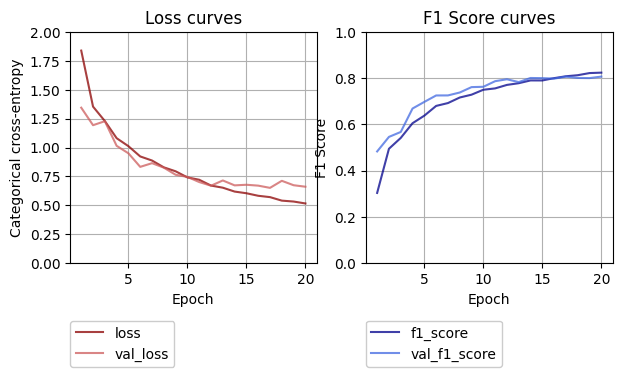

In [88]:
# Extracting evaluation metrics
acc_vgg_128, f1_vgg_128, loss_vgg_128, val_acc_vgg_128, val_f1_vgg_128, val_loss_vgg_128 = get_metrics(history_vggnet_19_128_32)

# Plotting the results
plot_training_history(history_vggnet_19_128_32)

In [89]:
data_128_others = {
    "Model": ["resnet34_128", "vggnet19_128"],  
    "Accuracy": [acc_dense_net_169_64, acc_vgg_128],  
    "F1_Score": [f1_dense_net_169_64, f1_vgg_128],  
    "Loss": [loss_dense_net_169_64, loss_vgg_128],  
    "Val_Accuracy": [val_acc_dense_net_169_64, val_acc_vgg_128],  
    "Val_F1_Score": [val_f1_dense_net_169_64, val_f1_vgg_128],  
    "Val_Loss": [val_loss_dense_net_169_64, val_loss_vgg_128]
}

# Print the updated data3
print(pd.DataFrame(data_128_others))

          Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0  resnet34_128  0.792378  0.789828  0.603852      0.598818      0.594387   
1  vggnet19_128  0.825250  0.824256  0.515877      0.805048      0.807117   

   Val_Loss  
0  1.486771  
1  0.660839  
